# EEL891 - 2023.02 - Trabalho 1

Este trabalho envolve construir um classificador para apoio à decisão de aprovação de crédito.

Este deve identificar, dentre os clientes que solicitam um produto de créditoe que cumprem os pré-requisitos essenciais para a aprovação do crédito, aqueles que apresentem alto risco de não conseguirem honrar o pagamento, tornando-se inadimplentes.

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

## 1. Lendo e organizando dados

Aqui estou lendo os dados de teste e treinamento dos arquivos csv e depois juntando-os em um só arquivo "credito_df" para que possamos fazer o pré-processamento de uma vez só.

"split_index" é uma variável para guardar o ponto de junção dos conjuntos de dados (corresponde ao primeiro índice de 'credito_df' que faz parte do test set) para que depois eles possam ser separados de novo. "id_soliciante" guarda os IDs dos solicitantes que terão seu campo 'inadimplente' previsto pelo modelo; estes IDs farão parte do arquivo de saída que será enviado ao Kaggle e foram separados para facilitar.

In [273]:
train = pd.read_csv('conjunto_de_treinamento.csv')
test = pd.read_csv('conjunto_de_teste.csv')

In [274]:
train.head()

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,...,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,...,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0
1,2,1,25,internet,1,F,38,1,0,0,...,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0
2,3,1,20,internet,1,F,37,2,0,0,...,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1
3,4,1,20,internet,1,M,37,1,1,0,...,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1
4,5,7,1,internet,1,F,51,1,3,0,...,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1


In [275]:
# Salvar id_solicitante para auxiliar na criação do arquivo que será enviado ao Kaggle
id_soliciante = test['id_solicitante']

# Criando um DF novo com o train e o test
credito_df = pd.concat([train, test], ignore_index=True)

In [276]:
# Para auxiliar no momento separar o DF credito_df em train e test
split_index = len(train)

In [277]:
credito_df

,id_solicitante,produto_solicitado,dia_vencimento,forma_envio_solicitacao,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,...,possui_telefone_trabalho,codigo_area_telefone_trabalho,meses_no_trabalho,profissao,ocupacao,profissao_companheiro,grau_instrucao_companheiro,local_onde_reside,local_onde_trabalha,inadimplente
0,1,1,10,presencial,1,M,85,2,0,0,...,N,,0,9.0,1.0,0.0,0.0,600.0,600.0,0.0
1,2,1,25,internet,1,F,38,1,0,0,...,N,,0,2.0,5.0,NaN,NaN,492.0,492.0,0.0
2,3,1,20,internet,1,F,37,2,0,0,...,N,,0,NaN,NaN,NaN,NaN,450.0,450.0,1.0
3,4,1,20,internet,1,M,37,1,1,0,...,Y,54,0,9.0,2.0,NaN,NaN,932.0,932.0,1.0
4,5,7,1,internet,1,F,51,1,3,0,...,N,,0,9.0,5.0,NaN,NaN,440.0,440.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24996,1,10,presencial,1,F,49,2,1,0,...,N,,0,9.0,1.0,0.0,0.0,652.0,652.0,NaN
24996,24997,1,5,internet,1,M,18,2,0,0,...,N,,0,NaN,NaN,NaN,NaN,855.0,855.0,NaN
24997,24998,1,10,presencial,1,F,29,1,0,0,...,N,,0,9.0,5.0,NaN,NaN,371.0,371.0,NaN
24998,24999,1,25,internet,1,F,31,2,2,0,...,N,,0,NaN,NaN,NaN,NaN,670.0,670.0,NaN


## 2. Preparação dos dados
Análise e preparação dos dados para treinamento.

### 2.1. Valores Nulos
Antes de tudo, é fundamental lidar com valores ausentes no conjunto de dados. Aqui, listei as colunas com valores nulos e analisei uma a uma para decidir como preencher esses valores. Além das colunas que realmente possuem 'null', também inclui as colunas 'sexo' e 'estado_onde_nasceu', que também tem valores faltando, como ressaltado no Dicionário de Dados.

In [278]:
columns_sum_nulls = credito_df.isnull().sum()
columns_with_nulls = columns_sum_nulls[columns_sum_nulls > 0]
columns_with_nulls

tipo_residencia                 661
meses_na_residencia            1812
profissao                      3859
ocupacao                       3668
profissao_companheiro         14401
grau_instrucao_companheiro    16070
inadimplente                   5000
dtype: int64

In [279]:
# Função para ajudar na vizualização das informações de cada coluna
def analysis(data, column, categorical = True):
    print(f'Number of Unique Values: {data[column].nunique()}')
    print(f'\nUnique Values: {data[column].unique()}')
    print(f'\nNumber of Null Values: {data[column].isnull().sum()}')
    #print(f'\nCount per Value: \n{data[column].value_counts()}')
    
    if categorical == True:
        sns.countplot(data = data, x = column, hue = 'inadimplente')
    else:
        sns.displot(data[column], kde = True)

#### 2.1.1 Tipo de Residência
Preenchi os nulos com o valor mais frequente (moda).

Number of Unique Values: 6

Unique Values: [ 1.  5.  0. nan  2.  3.  4.]

Number of Null Values: 661


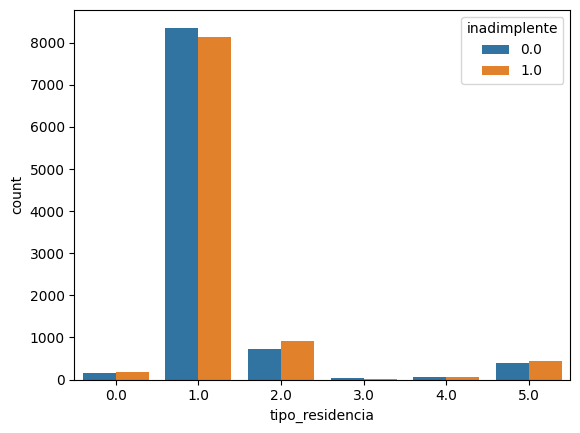

In [280]:
analysis(credito_df, 'tipo_residencia')

In [281]:
credito_df['tipo_residencia'] = credito_df['tipo_residencia'].fillna(1)

In [282]:
credito_df['tipo_residencia'].isnull().sum()

0

#### 2.1.2 Meses na Residência
Percebi que existe uma relação forte entre a quantidade de meses na residência e o tipo de residência, então atribuí para cada registro com nulo a média de meses do seu tipo de residência.

Number of Unique Values: 80

Unique Values: [ 12.   5.   1.   2.   0.   3.  15.  10.   4.  14.  16.   7.   8.  nan
  32.  20.  23.  30.  21.   6.  13.  27.  25.  19.  11.   9.  18.  41.
  40.  26.  38.  22.  24.  29.  17.  34.  37.  51.  49.  54.  35.  36.
  48.  50.  57.  28.  46.  58.  43.  45.  55.  31.  44.  39.  42.  33.
  53.  65.  78.  64.  60.  47.  80.  89.  72.  52.  68.  84.  61. 200.
  96. 100. 228.  71.  67.  56.  81.  59.  63.  62.  70.]

Number of Null Values: 1812


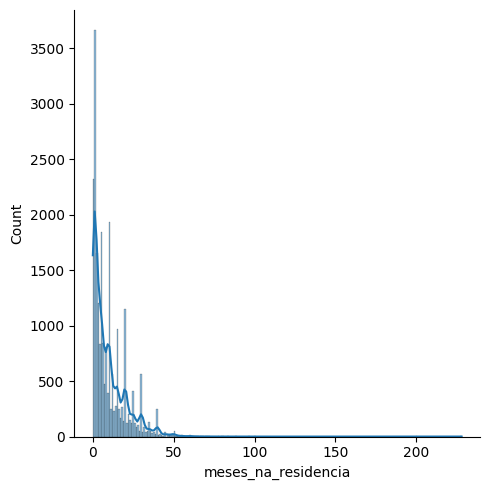

In [283]:
analysis(credito_df, 'meses_na_residencia', False)

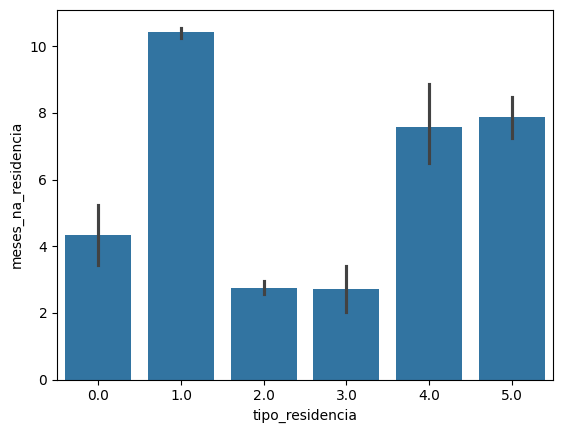

In [284]:
sns.barplot(x="tipo_residencia", y="meses_na_residencia", data=credito_df)
plt.show()

In [285]:
# Medias de cada tipo de residencia
avg_months_res = credito_df.groupby('tipo_residencia')['meses_na_residencia'].mean()
avg_months_res

tipo_residencia
0.0     4.323980
1.0    10.412271
2.0     2.745591
3.0     2.709091
4.0     7.578947
5.0     7.871560
Name: meses_na_residencia, dtype: float64

In [286]:
# Preenche os nulos com a média do tipo de residência associado
credito_df['meses_na_residencia'] = credito_df['meses_na_residencia'].fillna(credito_df['tipo_residencia'].map(avg_months_res))

In [287]:
credito_df['meses_na_residencia'].isnull().sum()

0

#### 2.1.3 Profissão e Ocupação
Essas colunas tem significados bem parecidos, em que provavelmente 'profissão' ofereça subgrupos para 'ocupação'. Além disso, foi observado que ambas possuem uma quantidade grande de nulos; na maior parte das vezes ambas estão nulas no mesmo registro.

Como as duas colunas são semelhantes, decidi por remover 'profissao' por ser menos geralizada, além de não se mostrar tão relevante assim para determinação do campo alvo 'inadimplente'. Quanto aos nulos de 'ocupação', preenchi com a moda.

Number of Unique Values: 19

Unique Values: [ 9.  2. nan 10.  7. 11.  0. 12.  8. 17. 16.  6. 13. 15. 14.  4.  3.  5.
  1. 18.]

Number of Null Values: 3859


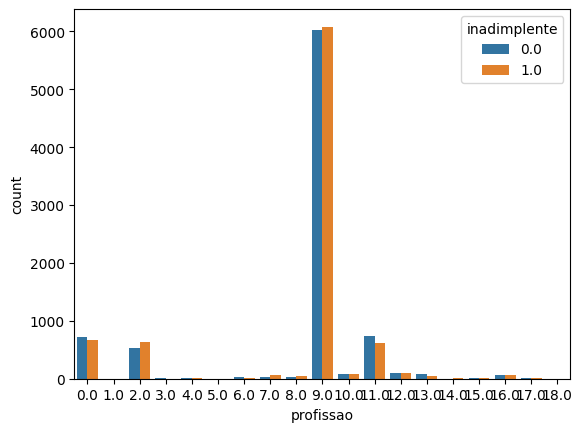

In [288]:
analysis(credito_df, 'profissao')

Number of Unique Values: 6

Unique Values: [ 1.  5. nan  2.  4.  0.  3.]

Number of Null Values: 3668


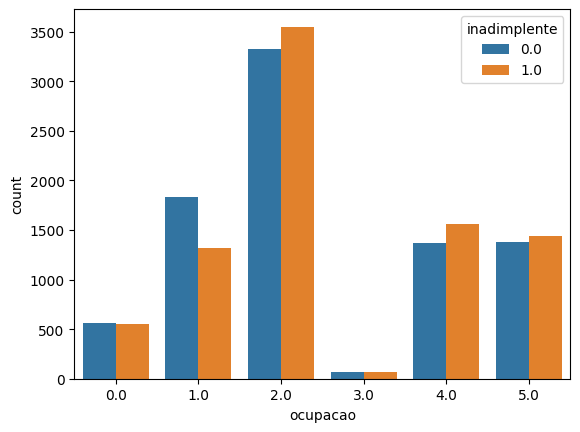

In [289]:
analysis(credito_df, 'ocupacao')

In [290]:
# Procurando quantidade de nulos nos outros campos quando 'ocupacao' em si é nulo
credito_df[pd.isnull(credito_df['ocupacao'])].isnull().sum()

id_solicitante                         0
produto_solicitado                     0
dia_vencimento                         0
forma_envio_solicitacao                0
tipo_endereco                          0
sexo                                   0
idade                                  0
estado_civil                           0
qtde_dependentes                       0
grau_instrucao                         0
nacionalidade                          0
estado_onde_nasceu                     0
estado_onde_reside                     0
possui_telefone_residencial            0
codigo_area_telefone_residencial       0
tipo_residencia                        0
meses_na_residencia                    0
possui_telefone_celular                0
possui_email                           0
renda_mensal_regular                   0
renda_extra                            0
possui_cartao_visa                     0
possui_cartao_mastercard               0
possui_cartao_diners                   0
possui_cartao_am

In [291]:
credito_df['ocupacao'] = credito_df['ocupacao'].fillna(2)

In [292]:
credito_df = credito_df.drop(columns='profissao')

#### 2.1.4 Profissão e Grau de Instrução do Companheiro
Esses dois campos possuem uma quantidade enorme de nulos, mais da metade do conjunto de dados. Então, optei por não usar esses campos para o treinamento do modelo e os removi do conjunto de dados.

In [293]:
credito_df = credito_df.drop(columns=['profissao_companheiro', 'grau_instrucao_companheiro'])

In [294]:
credito_df.columns

Index(['id_solicitante', 'produto_solicitado', 'dia_vencimento',
       'forma_envio_solicitacao', 'tipo_endereco', 'sexo', 'idade',
       'estado_civil', 'qtde_dependentes', 'grau_instrucao', 'nacionalidade',
       'estado_onde_nasceu', 'estado_onde_reside',
       'possui_telefone_residencial', 'codigo_area_telefone_residencial',
       'tipo_residencia', 'meses_na_residencia', 'possui_telefone_celular',
       'possui_email', 'renda_mensal_regular', 'renda_extra',
       'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'possui_carro',
       'vinculo_formal_com_empresa', 'estado_onde_trabalha',
       'possui_telefone_trabalho', 'codigo_area_telefone_trabalho',
       'meses_no_trabalho', 'ocupacao', 'local_onde_reside',
       'local_onde_trabalha', 'inadimplente'],
      dtype='object')

#### 2.1.5 Sexo e Estado Onde Nasceu/Trabalha
Esses campos não possuem 'null' mas possuem registros iguais a um espaço vazio (' '), o que possui o mesmo significado. Aqui meu intuito era preencher todos os registros vazios com 'Não Identificado' (N) no caso do sexo, e 'XX' no caso dos estado de nascimento/trabalho. 

No entanto, percebi que haviam muitos registros de estado de trabalho vazios (mais da metade) e, considerando que a coluna 'estado_onde_reside' já possui uma forte ligação com o estado de trabalho e não possui registros vazios, decidi remover a coluna. De resto, fiz como planejado.

In [295]:
# Verificando quantidade de registros vazios
credito_df[credito_df['sexo'] == ' ']['id_solicitante'].count()

11

In [296]:
credito_df[credito_df['estado_onde_nasceu'] == ' ']['id_solicitante'].count()

1032

In [297]:
credito_df[credito_df['estado_onde_trabalha'] == ' ']['id_solicitante'].count()

17006

In [298]:
credito_df[credito_df['estado_onde_reside'] == ' ']['id_solicitante'].count()

0

In [299]:
credito_df = credito_df.drop(columns=['estado_onde_trabalha'])

In [300]:
# Substituindo espaços vazios
credito_df.loc[credito_df['sexo'] == ' ', 'sexo'] = 'N'
credito_df.loc[credito_df['estado_onde_nasceu'] == ' ', 'estado_onde_nasceu'] = 'XX'

### 2.2. Modificação de Features
Aqui fiz uma breve análise de como 'otimizar' algumas features para melhores previsões. Na realidade, decidi modificar apenas as features que se referem a siglas dos estados brasileiros (estado onde nasceu e estado onde reside). Essas features possuem categorias demais, que podem ser dividas em regiões e possivelmente seriam mais relevantes nesse formato, além de otimizar o treinamento.

In [301]:
state_to_region = {
    'AC': 'Norte',
    'AL': 'Nordeste',
    'AP': 'Norte',
    'AM': 'Norte',
    'BA': 'Nordeste',
    'CE': 'Nordeste',
    'DF': 'Centro-Oeste',
    'ES': 'Sudeste',
    'GO': 'Centro-Oeste',
    'MA': 'Nordeste',
    'MT': 'Centro-Oeste',
    'MS': 'Centro-Oeste',
    'MG': 'Sudeste',
    'PA': 'Norte',
    'PB': 'Nordeste',
    'PR': 'Sul',
    'PE': 'Nordeste',
    'PI': 'Nordeste',
    'RJ': 'Sudeste',
    'RN': 'Nordeste',
    'RS': 'Sul',
    'RO': 'Norte',
    'RR': 'Norte',
    'SC': 'Sul',
    'SP': 'Sudeste',
    'SE': 'Nordeste',
    'TO': 'Norte',
    'XX': 'Unknown'
}

In [302]:
credito_df['estado_onde_nasceu'] = credito_df['estado_onde_nasceu'].map(state_to_region)
credito_df['estado_onde_reside'] = credito_df['estado_onde_reside'].map(state_to_region)

In [303]:
credito_df['estado_onde_nasceu'].unique()

array(['Nordeste', 'Sul', 'Sudeste', 'Centro-Oeste', 'Norte', 'Unknown'],
      dtype=object)

### 2.3. Codificação de Variáveis Categóricas
Aqui convertemos variáveis categóricas em representações binárias, criando colunas one-hot, para que possam ser usadas nos algoritmos de machine learning.

Foi observado que 'local_onde_reside' e 'local_onde_trabalha' possuem muitas categorias e resultariam em muitas colunas extras que provavelmente não seriam tão relevantes assim. Como não temos informações sobre esses locais para dividirmos em áreas, decidi dropar essas colunas.

In [304]:
credito_df = credito_df.drop(columns=['local_onde_reside', 'local_onde_trabalha'])

In [305]:
credito_df.columns

Index(['id_solicitante', 'produto_solicitado', 'dia_vencimento',
       'forma_envio_solicitacao', 'tipo_endereco', 'sexo', 'idade',
       'estado_civil', 'qtde_dependentes', 'grau_instrucao', 'nacionalidade',
       'estado_onde_nasceu', 'estado_onde_reside',
       'possui_telefone_residencial', 'codigo_area_telefone_residencial',
       'tipo_residencia', 'meses_na_residencia', 'possui_telefone_celular',
       'possui_email', 'renda_mensal_regular', 'renda_extra',
       'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'possui_carro',
       'vinculo_formal_com_empresa', 'possui_telefone_trabalho',
       'codigo_area_telefone_trabalho', 'meses_no_trabalho', 'ocupacao',
       'inadimplente'],
      dtype='object')

In [306]:
categorical_variables = ['produto_solicitado', 'dia_vencimento', 'forma_envio_solicitacao', 'tipo_endereco', 'sexo', 'estado_civil',
                        'grau_instrucao', 'nacionalidade', 'estado_onde_nasceu', 'estado_onde_reside', 
                        'possui_telefone_residencial', 'codigo_area_telefone_residencial', 'tipo_residencia', 'possui_telefone_celular',
                        'possui_email', 'possui_cartao_visa', 'possui_cartao_mastercard', 'possui_cartao_diners', 'possui_cartao_amex', 
                        'possui_outros_cartoes', 'possui_carro', 'vinculo_formal_com_empresa', 'possui_telefone_trabalho', 
                        'codigo_area_telefone_trabalho', 'ocupacao']

In [307]:
# drop_first tira a primeira coluna, de forma que se as outras são zero, ela é a 'selecionada'
for variable in categorical_variables:
    credito_df = pd.get_dummies(credito_df, columns=[variable], prefix=[variable], drop_first = True)

### 2.4. Normalização/Padronização
Normalizando as colunas numéricas para garantir que as features tenham escalas comparáveis.

In [308]:
normalize_data = ['idade', 'qtde_dependentes', 'meses_na_residencia', 'renda_mensal_regular', 'renda_extra', 
                'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais', 'valor_patrimonio_pessoal', 
                'meses_no_trabalho']
scaler = MinMaxScaler() 

# Aplicar a normalização aos dados
credito_df[normalize_data] = scaler.fit_transform(credito_df[normalize_data])

### 2.4. Dividir os dados de novo
Redividindo os dados em conjunto de treinamento e testes. Vou usar todas as colunas que restaram para o treinamento, menos obviamente o id dos solicitantes.

In [309]:
credito_df = credito_df.drop(columns='id_solicitante')

In [310]:
train = credito_df[:split_index].copy()
test = credito_df[split_index:].copy()

In [311]:
train['inadimplente'] = train['inadimplente'].astype(int)

In [312]:
X_train = train.drop('inadimplente', axis = 1)
y_train = train['inadimplente']
X_test = test.drop('inadimplente', axis = 1)

## 3. Modelo

### 3.1. Selecionar melhor modelo
Aqui fiz um loop ao longo dos modelos que escolhi para testar, e calculei a acurácia média de cada um através de validação cruzada.

In [313]:
# Lista de modelos a serem testados
models = {
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SGD Classifier': SGDClassifier(),
}

In [314]:
# Loop através dos modelos e imprime o desempenho usando validação cruzada
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} - Mean Accuracy: {np.mean(scores):.4f}")

Random Forest - Mean Accuracy: 0.5757
Logistic Regression - Mean Accuracy: 0.5895
Decision Tree - Mean Accuracy: 0.5340
K-Nearest Neighbors - Mean Accuracy: 0.5401
Naive Bayes - Mean Accuracy: 0.5080
Gradient Boosting - Mean Accuracy: 0.5944
SGD Classifier - Mean Accuracy: 0.5766


### 3.2. Ajuste de hiperparâmetros
Tendo selecionado o melhor modelo na etapa anterior, otimizei os hiperparâmetros para reduzir o erro de validação cruzada. Para isso, usei pesquisa em grade (Grid Search).

In [315]:
# Hiperparâmetros para ajustar
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0]
}

In [316]:
gb = GradientBoostingClassifier()

grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy', verbose=20000)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV 1/5; 1/216] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8


[CV 1/5; 1/216] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.578 total time=   8.2s
[CV 2/5; 1/216] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8
[CV 2/5; 1/216] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.573 total time=   7.8s
[CV 3/5; 1/216] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8
[CV 3/5; 1/216] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.585 total time=   8.2s
[CV 4/5; 1/216] START learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8
[CV 4/5; 1/216] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.581

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy', verbose=20000)

In [317]:
best_params = grid_search.best_params_
print(f"Best Hiperparameters: {best_params}")

Best Hiperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


### 3.3. Treinar o modelo
Treinando o modelo com os melhores hiperparâmetros encontrados no conjunto de treinamento completo.

In [318]:
# Treinando o modelo com os melhores hiperparâmetros no conjunto de treinamento completo
best_gb = GradientBoostingClassifier(**best_params)
best_gb.fit(X_train, y_train)

GradientBoostingClassifier(min_samples_leaf=2, n_estimators=200, subsample=0.8)

### 3.4. Fazer previsões
Fazendo previsões no conjunto de testes usando o modelo que foi treinado.

In [319]:
# Fazer previsões no conjunto de testes
best_gb_pred = best_gb.predict(X_test)

## 4. Arquivo de respostas
Aqui estou criando o arquivo de respostas com as previsões, que será enviado ao Kaggle.

In [320]:
kaggle = pd.DataFrame({'id_solicitante': id_soliciante, 'inadimplente': best_gb_pred})

In [321]:
kaggle.to_csv('AprvCredito.csv', index = False)

In [322]:
kaggle

,id_solicitante,inadimplente
0,20001,1
1,20002,0
2,20003,1
3,20004,0
4,20005,0
...,...,...
4995,24996,1
4996,24997,1
4997,24998,1
4998,24999,1
